In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle # para leer los archivos comprimidos (.p)
#%pip install matplotlib
#%pip install mpl-interactions
#%pip install ipympl
from IPython.core.display import display, HTML
#remove paddingss
display(HTML(
    '<style>'
        '#notebook { padding-top:0px !important; } ' 
        '.container { width:100% !important; } '
        '.end_space { min-height:0px !important; } '
    '</style>'
))
#parameters#####################
nsensores =3 # 1 a 4
SampleFreq=1400
nombreArchivo = './mediciones/07112023_3s______ok.p' #26102023.p' #'./datos/3sens_130423_2.p' #  './datos/oclusion_bien.p'

#############################

with open(nombreArchivo, 'rb') as f:
    data = pickle.load(f)
    print("Datos extraidos de %s" %nombreArchivo)
    f.close()
    
s0_raw = data['sensor0']
if nsensores >= 2 :    s1_raw = data['sensor1']
if nsensores >= 3 :    s2_raw = data['sensor2']
if nsensores >= 4 :    s3_raw = data['sensor3']

n_samples = len(s0_raw) #1.5*60*2000 #min*60*fsamp

Datos extraidos de ./mediciones/07112023_3s______ok.p


<IPython.core.display.Javascript object>


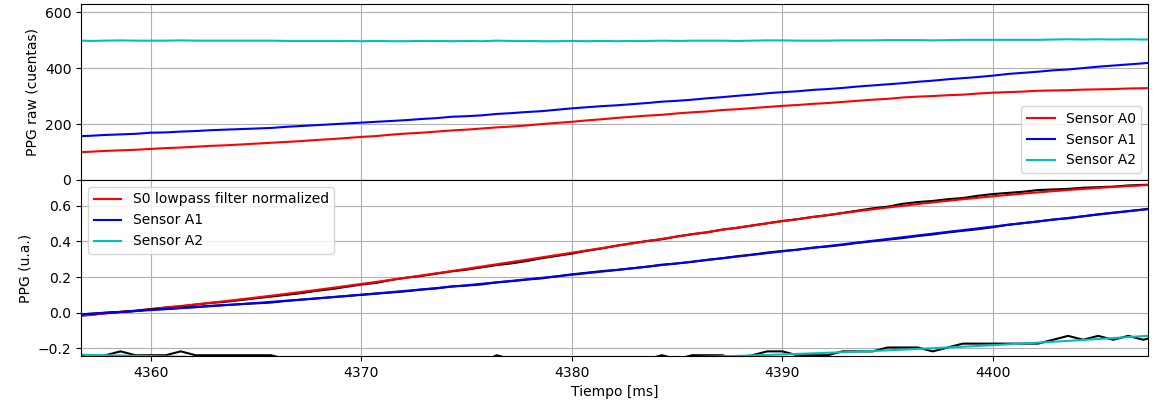

In [2]:
#preprocesamiento: normalizo y filtro señales

#enables zoom on figs:
%matplotlib notebook 

#-parameters-------------------------------------------------------------------
t_sec_discarded = 0.250
lp_cutoff_hz = 20      # desired cutoff frequency of the filter, Hz ,
lp_order = 3


# grafico señales sin procesar-----------------------------------------------------
fig = plt.figure(figsize = (11.6, 4)); ax0 = plt.subplot(211); ax0.margins(0, 0) #fig.suptitle('test title', fontsize=20)
SampleFreqKHz = SampleFreq/1000
#time_raw = np.arange(0, n_samples/SampleFreqKHz, 1/SampleFreqKHz) #; time = time[:n_samples]  #start stop step
time_raw = np.linspace(1/SampleFreqKHz, n_samples/SampleFreqKHz, n_samples) #; time = time[:n_samples]  #start stop step
#numpy.linspace start stop num
plt.plot(time_raw, s0_raw, 'r', label="Sensor A0")
if nsensores >= 2 :    plt.plot(time_raw, s1_raw, 'b', label="Sensor A1")
if nsensores >= 3 :    plt.plot(time_raw, s2_raw, 'c', label="Sensor A2")
if nsensores >= 4 :    plt.plot(time_raw, s3_raw, 'g', label="Sensor A3")
plt.xlabel("Tiempo [ms]"), plt.ylabel("PPG raw (cuentas)")#, plt.title("Señales ")
plt.legend(), plt.grid(), plt.setp(ax0.get_xticklabels(), visible=False), plt.show()

# normalizo y filtro #####################################################################

#descarto primeras muestras--
n_discarded = round(t_sec_discarded*SampleFreq) #
s0_trunc = s0_raw[n_discarded:] 
time = time_raw[n_discarded:] 
if nsensores >= 2 :    s1_trunc = s1_raw[n_discarded:] 
if nsensores >= 3 :    s2_trunc = s2_raw[n_discarded:] 
if nsensores >= 4 :    s3_trunc = s3_raw[n_discarded:] 

#filtro PB---------------------------------------------    
from scipy.signal import butter,filtfilt
def butter_lowpass_filter(data, cutoff, fs, order):
    nyq = 0.5 * fs
    normal_cutoff = lp_cutoff_hz / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)# Get the filter coefficients 
    y = filtfilt(b, a, data)
    return y

# normalizo  datos.--------------------------------------------
# resto valor medio y divido por el max
ax1 = plt.subplot(212, sharex = ax0); ax1.margins(0, 0)
s0_mean = s0_trunc - round(np.mean(s0_trunc)); 
s0_norm = s0_mean/np.max(s0_mean);# s0_nf = s0
plt.plot(time, s0_norm, 'k')
s0 = butter_lowpass_filter(s0_norm, lp_cutoff_hz, SampleFreq, order=lp_order)
plt.plot(time, s0, 'r', label="S0 lowpass filter normalized")
if nsensores >= 2 :
    s1_mean = s1_trunc - round(np.mean(s1_trunc));    
    s1_norm = s1_mean/np.max(s1_mean); #   s1_nf = s1;
    plt.plot(time, s1_norm, 'k')
    s1 = butter_lowpass_filter(s1_norm, lp_cutoff_hz, SampleFreq, order=lp_order)
    plt.plot(time, s1, 'b', label="Sensor A1")
if nsensores >= 3 :
    s2_mean = s2_trunc - round(np.mean(s2_trunc));     
    s2_norm = s2_mean/np.max(s2_mean);  # s2_nf = s2;
    s2 = butter_lowpass_filter(s2_norm, lp_cutoff_hz, SampleFreq, order=lp_order)
    plt.plot(time, s2_norm, 'k')
    plt.plot(time, s2, 'c', label="Sensor A2")
if nsensores >= 4 :
    s3_mean = s3_trunc - round(np.mean(s3_trunc));     
    s3_norm = s3_mean/np.max(s3_mean);  #   s3_nf = s3;
    s3 = butter_lowpass_filter(s3_norm, lp_cutoff_hz, SampleFreq, order=lp_order)
    plt.plot(time, s3_norm, 'k')
    plt.plot(time, s3, 'g', label="Sensor A3")

plt.xlabel("Tiempo [ms]"), plt.ylabel("PPG (u.a.)")#, plt.title("Señales normalizadas")
plt.legend(), plt.grid(), plt.subplots_adjust(hspace=.0) # remove vertical gap between subplots
plt.subplots_adjust(left=0.07, right=.99, top=.99, bottom=.11)
plt.show()



<IPython.core.display.Javascript object>


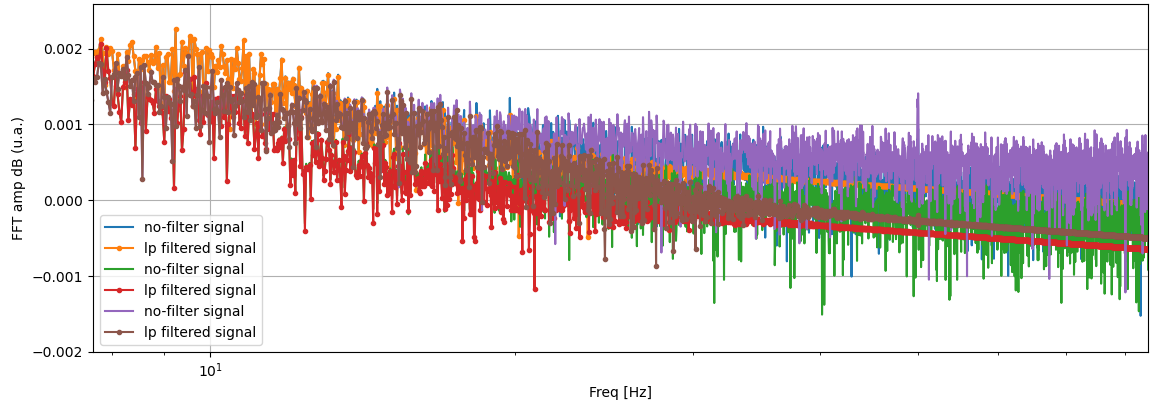

In [5]:
from scipy.fft import fft, fftfreq

N = len(s0)  #freq points
yf = fft(s0)
yf_nf=  fft(s0_norm) 
xf = np.linspace(SampleFreq/(N//2), SampleFreq//2, N//2, endpoint=False)


fig = plt.figure(figsize = (11.6, 4));  ax0.margins(0, 0) #fig.suptitle('test title', fontsize=20)
plt.subplots_adjust(left=0.08, right=.99, top=.99, bottom=.12)
plt.plot(xf, 2.0/N * 20 * np.log10(np.abs(yf_nf[0:N//2])), label="no-filter signal")
plt.plot(xf, 2.0/N * 20 * np.log10(np.abs(yf[0:N//2])), marker=".", label="lp filtered signal")
plt.xscale('log'), plt.grid(), plt.xlabel("Freq [Hz]"), plt.ylabel("FFT amp dB (u.a.)"), plt.legend(), plt.show();

if nsensores >= 2 :  
    N = len(s1)  #freq points
    yf = fft(s1)
    yf_nf=  fft(s1_norm) 
   # fig = plt.figure(figsize = (11.6, 4));  ax0.margins(0, 0) #fig.suptitle('test title', fontsize=20)
    plt.subplots_adjust(left=0.08, right=.99, top=.99, bottom=.12)
    plt.plot(xf, 2.0/N * 20 * np.log10(np.abs(yf_nf[0:N//2])), label="no-filter signal")
    plt.plot(xf, 2.0/N * 20 * np.log10(np.abs(yf[0:N//2])), marker=".", label="lp filtered signal")
    plt.xscale('log'), plt.grid(), plt.xlabel("Freq [Hz]"), plt.ylabel("FFT amp dB (u.a.)"), plt.legend(), plt.show();
    
if nsensores >= 3 :  
    N = len(s2)  #freq points
    yf = fft(s2)
    yf_nf=  fft(s2_norm) 
   # fig = plt.figure(figsize = (11.6, 4));  ax0.margins(0, 0) #fig.suptitle('test title', fontsize=20)
    plt.subplots_adjust(left=0.08, right=.99, top=.99, bottom=.12)
    plt.plot(xf, 2.0/N * 20 * np.log10(np.abs(yf_nf[0:N//2])), label="no-filter signal")
    plt.plot(xf, 2.0/N * 20 * np.log10(np.abs(yf[0:N//2])), marker=".", label="lp filtered signal")
    plt.xscale('log'), plt.grid(), plt.xlabel("Freq [Hz]"), plt.ylabel("FFT amp dB (u.a.)"), plt.legend(), plt.show();

<IPython.core.display.Javascript object>


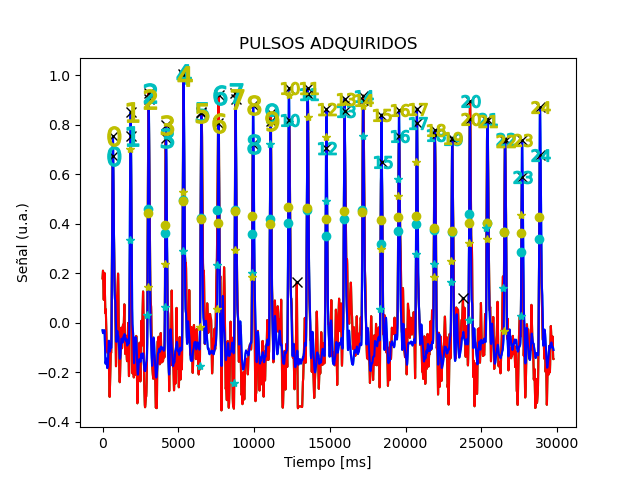

27
25


<IPython.core.display.Javascript object>


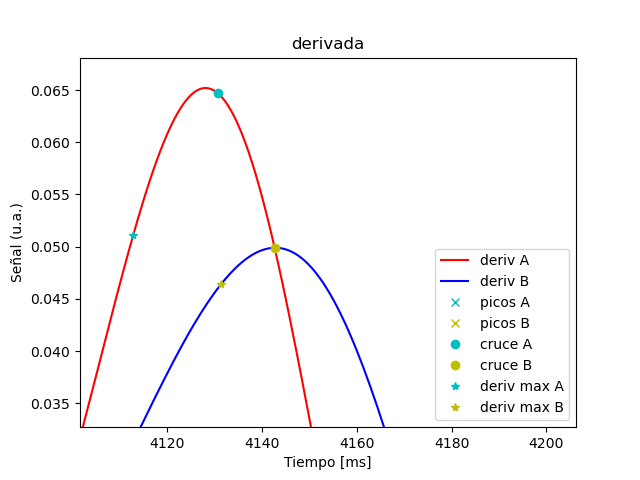

<IPython.core.display.Javascript object>


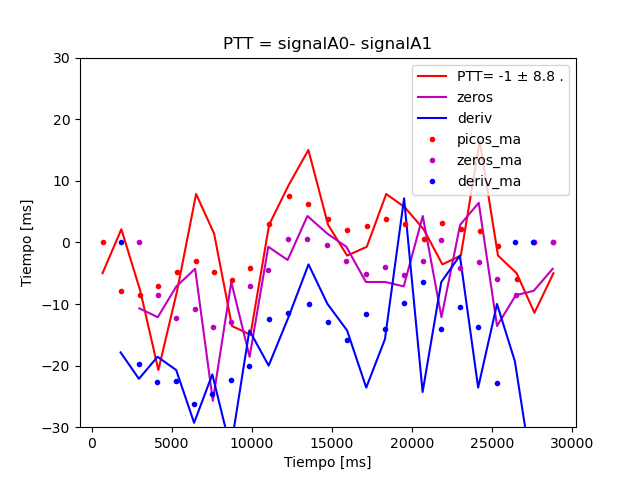

<IPython.core.display.Javascript object>


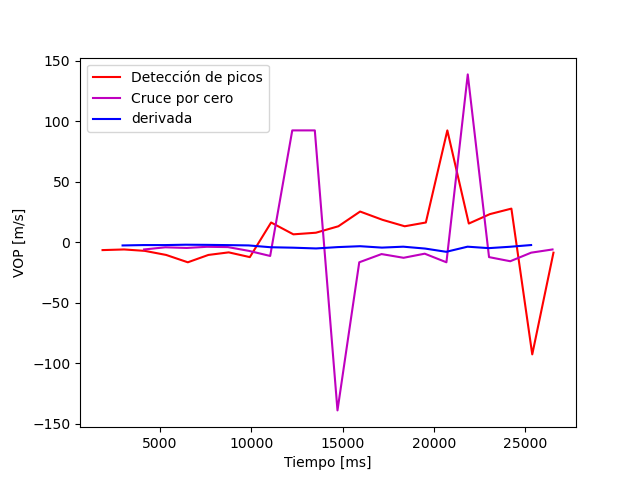

C:\Users\Leonardo Casal\AppData\Local\Temp\ipykernel_4160\2788182207.py:297: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(time_ms[peaks0_ma],                   DISTANCIA_mts*1000/delta_T_ma_ma,    'r-', label='Detección de picos')    #  ptt con media movil
C:\Users\Leonardo Casal\AppData\Local\Temp\ipykernel_4160\2788182207.py:298: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(time_ms[last_zeros_crossing_array0],  DISTANCIA_mts*1000/delta_T_zeros_ma, 'm-', label='Cruce por cero')   #  ptt detectada con cruce por cero
C:\Users\Leonardo Casal\AppData\Local\Temp\ipykernel_4160\2788182207.py:299: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(time_ms[deriv_max_array0],            DISTANCIA_mts*1000/delta_T_deriv_ma, 'b-', label='derivada')      #  ptt detectada con reconstrucción derivada


<IPython.core.display.Javascript object>


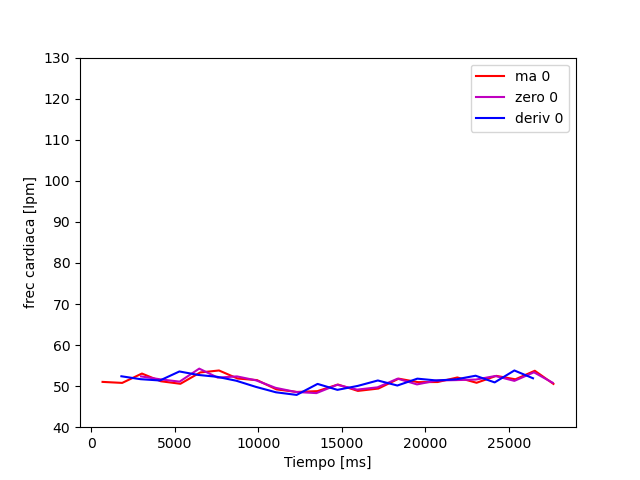

(40.0, 130.0)

In [21]:
#aplico filtro media movil, detecto picos, descarto picos sin pareja
#buscamos cruce por cero, derivada
#descarto latidos borde
#calculo delta_T de diferentes maneras
#calculo frec de diferentes maneras
#aplico filtro media movil a delta T
#calculo VOP
#grafico

#DISTANCIA_mts=0.36 #0.36 .04y 0.08 # VOP VELOCIDAD DE ONDA DE PULSO--------------

DISTANCIA_mts=0.05 #.47 codo punta dedo// 0.26codo muñeca // .21 muñeca punta dedo dedo a dedod .055 #0.36 .04y 0.08 # VOP VELOCIDAD DE ONDA DE PULSO--------------


#DETECTOR DE PICOS-------------------------------------------------------------------------------------------------------
from scipy.signal import find_peaks
# minimum height for a peak to be recognized.
# minimum distance for a peak to be recognized.
#peaks_min_time_ms = 900/SampleFreqKHz # = 450 ms -> 60/.450 = 133 bpm max_bpm = 60/(distance/SampleFreq_Hz)  60*2000/133
bpm_max = 133
distance = round(60*SampleFreq/bpm_max)
peaks0, _ = find_peaks(s0, distance=distance,height=0.1, width=50)
peaks1, _ = find_peaks(s1, distance=distance,height=0.1, width=50)# rojo

# DETECTOR DE PICOS sobre la señal con filtrada CON MEDIA MÓVIL
peaks0_ma, _ = find_peaks(s0, distance=distance,height=0.1, width=50)
peaks1_ma, _ = find_peaks(s1, distance=distance,height=0.1, width=50)# rojo

"""
beats_power_array0 = np.zeros(len(peaks0_ma)-2);
for n_beat in range(1,len(peaks0_ma)-1):
    latido = s0[peaks0_ma[n_beat]:peaks0_ma[n_beat+1]] 
    beats_power_array0[n_beat-1] = np.abs(latido)**2


np.power(x1, 3)
"""

#discard peaks with no matching peak at both signals (when difference is greater than 100ms)
ptt_max_ms = 40       
i = -1
#for j in range(0,min(len(peaks1_ma),len(peaks0_ma))):
while  i< min(len(peaks1_ma),len(peaks0_ma))-1:
    i = i+1
    #print("j: " + str(j) + " len(peaks1_ma)=" + str(len(peaks1_ma)) + ", len(peaks1_ma)= " + str(len(peaks1_ma)))
    #print("j: " + str(j)+ " len(peaks1_ma)=" + str(len(peaks1_ma))
    #print(i)
    #print(peaks0_ma[i])
    if abs(peaks0_ma[i] - peaks1_ma[i])/SampleFreqKHz > ptt_max_ms: #peak1 with beat, peak0 no beat 
        if peaks0_ma[i] < peaks1_ma[i]:
            #print("discarded peak after beat nr "+str(i-1)+" at "+str(peaks0_ma[i]/SampleFreq)+" for signal 0 (next peak at signal1 was at "+str(peaks1_ma[i]/SampleFreq)+" >100ms after beat at signal0)")
            peaks0_ma[i:-1] = peaks0_ma[i+1:] #discard beat with no matching beat
            peaks0_ma = peaks0_ma[:-1] #and discard last beat (repeated)
        else :
            #print("discarded peak after beat nr "+str(i-1)+" at "+str(peaks1_ma[i]/SampleFreq)+" for signal 1 (next peak at signal0 was at "+str(peaks0_ma[i]/SampleFreq)+" >100ms after beat at signal1)")
            peaks1_ma[i:-1] = peaks1_ma[i+1:] #discard beat with no matching beat
            peaks1_ma = peaks1_ma[:-1] #and discard last beat (repeated), achico array
        i = i-1 #dont increase beat if theres no match
    #else:
        #print("beat nr "+str(i)+" at "+str(peaks1_ma[i]/SampleFreq)+" for signal 1 and "+str(peaks0_ma[i]/SampleFreq)+" signal0, diff="+str(peaks0_ma[i]-peaks1_ma[i]) )
    
"""
    if (peaks0_ma[i] - peaks1_ma[i])/SampleFreqKHz > 100: #peak1 with beat, peak0 no beat 
        print("discarded peak nr "+str(j)+" at "+str(peaks1_ma[i])+" for signal 1 (beat at signal0 was >100ms after beat at signal1)")
        peaks1_ma[i:-1] = peaks1_ma[i+1:] #discard beat with no matching beat
        #i = i-1 #dont increase beat if theres no match
        peaks1_ma = peaks1_ma[:-1] #discard last beat, achico array
    if (peaks1_ma[i] - peaks0_ma[i])/SampleFreqKHz > 100:  #peak0 with beat, peak1 no beat 
        #peaks0 = peaks0[1:] 
        print("discarded peak nr "+str(j)+" at "+str(peaks0_ma[i])+" for signal 0 (beat at signal1 was >100ms after beat at signal0)")
        peaks0_ma[i:-1] = peaks0_ma[i+1:] #discard beat with no matching beat
        peaks0_ma = peaks0_ma[:-1] #discard last beat, achico array
        #i = i-1
"""
   
#-buscamos cruce por cero-----------------------------------------------------------------------
last_zeros_crossing_array0 = np.zeros(len(peaks0_ma)-2);
len_beat_prev = peaks0_ma[1];
for n_beat in range(1,len(peaks0_ma)-1):
    latido = s0[peaks0_ma[n_beat]:peaks0_ma[n_beat+1]] 
    latido = latido - .5*s0[peaks0_ma[n_beat+1]]  #((np.max(latido)-np.min(latido))
    zero_crossings = np.where(np.diff(np.sign(latido)))[0]
    if len(zero_crossings) > 0:
        last_zeros_crossing_array0[n_beat-1] = int(len_beat_prev + zero_crossings[-1])
    len_beat_prev = len_beat_prev + len(latido)
last_zeros_crossing_array0 = last_zeros_crossing_array0.astype(int)

last_zeros_crossing_array1 = np.zeros(len(peaks1_ma)-2);
len_beat_prev = peaks1_ma[1];
for n_beat in range(1,len(peaks1_ma)-1):
    latido = s1[peaks1_ma[n_beat]:peaks1_ma[n_beat+1]]   
    latido = latido - .5*s1[peaks1_ma[n_beat+1]]  #(np.max(latido)-np.min(latido))
    zero_crossings = np.where(np.diff(np.sign(latido)))[0]
    if len(zero_crossings) > 0:
        last_zeros_crossing_array1[n_beat-1] = int(len_beat_prev + zero_crossings[-1])
    len_beat_prev = len_beat_prev + len(latido)
last_zeros_crossing_array1 = last_zeros_crossing_array1.astype(int)

# calculamos derivada #####
deriv_window_time_ms = 250 # ventana temporal sistolica (desde pico del latido) donde busco maxima derivada
n_deriv_samples = 5# 120 #14.9 50, 15 70, 12.3 100, 11.7 110, 9.7 115, 8.8 120, 11.5 130, 11.3 150,11.6 170, 11.2 200, 17.2 250 
deriv0 =  s0[n_deriv_samples:] - s0[:-n_deriv_samples]
# buscamos el max dentro de cada latido #####
deriv_max_array0 = np.zeros(len(peaks0_ma)-2);
len_beat_prev = peaks0_ma[1]; #si ponemos cero no coincide el pico con el maximo en el grafico
for n_beat in range(1,len(peaks0_ma)-1):
    latido_len = len(deriv0[peaks0_ma[n_beat]:peaks0_ma[n_beat+1]])
    #buscar maxima derivada desde el pico de ppg  y la mitad del latido
    deriv0[peaks0_ma[n_beat]+1:peaks0_ma[n_beat+1]-round(deriv_window_time_ms/1000*SampleFreq)] = 0
#    deriv0[peaks0_ma[n_beat]+1:round((peaks0_ma[n_beat]+peaks0_ma[n_beat+1])/frac_time_deriv+200)] = 0
    latido_deriv = deriv0[peaks0_ma[n_beat]:peaks0_ma[n_beat+1]] 
    deriv_max0 = np.argmax(latido_deriv)
    deriv_max_array0[n_beat-1] = int(len_beat_prev + deriv_max0)
    len_beat_prev = len_beat_prev + latido_len
deriv_max_array0 = deriv_max_array0.astype(int)

deriv1 =  s1[n_deriv_samples:] - s1[:-n_deriv_samples]
deriv_max_array1 = np.zeros(len(peaks1_ma)-2);
len_beat_prev = peaks1_ma[1];
for n_beat in range(1,len(peaks1_ma)-1):
    latido_len = len(deriv1[peaks1_ma[n_beat]:peaks1_ma[n_beat+1]])
    deriv1[peaks1_ma[n_beat]+1:peaks1_ma[n_beat+1]-round(deriv_window_time_ms/1000*SampleFreq)] = 0
#    deriv1[peaks1_ma[n_beat]+1:round((peaks1_ma[n_beat]+peaks1_ma[n_beat+1])/frac_time_deriv+200)] = 0
    latido_deriv = deriv1[peaks1_ma[n_beat]:peaks1_ma[n_beat+1]] 
    deriv_max1 = np.argmax(latido_deriv)
    deriv_max_array1[n_beat-1] = int(len_beat_prev + deriv_max1)
    len_beat_prev = len_beat_prev + latido_len
deriv_max_array1 = deriv_max_array1.astype(int)

    
#corrijo indices para que todos los vectores tengasn la misma longitud#################
"""len0 = min(len(peaks1),len(peaks0),len(peaks1_ma),len(peaks0_ma)) - 1
#len0 = min(len(peaks1),len(peaks0))
#peaks0 = peaks0[:min(len(peaks1),len(peaks0))]
#peaks1 = peaks1[:min(len(peaks1),len(peaks0))]
#len0 = min(len(peaks1_ma),len(peaks0_ma))
peaks0_ma = peaks0_ma[:min(len(peaks1_ma),len(peaks0_ma))]
peaks1_ma = peaks1_ma[:min(len(peaks1_ma),len(peaks0_ma))]

len0 = min(len(last_zeros_crossing_array0),len(last_zeros_crossing_array1))
last_zeros_crossing_array0 = last_zeros_crossing_array0[:len0]
last_zeros_crossing_array1 = last_zeros_crossing_array1[:len0]

len0 = min(len(deriv_max_array0),len(deriv_max_array1))
deriv_max_array0 = deriv_max_array0[:len0]
deriv_max_array1 = deriv_max_array1[:len0]
"""

# CUENTO LATIDOS frec cardiaca---------------------------------------------------------------------------------------------------------
heart_period_samples = abs(peaks1[:-1] - peaks1[1:])
heart_period_ms = heart_period_samples/SampleFreqKHz #conivierto muestras a tiempo
frec0 = 60*1000/heart_period_ms #convierto ms a minutos

heart_period_samples_ma = abs(peaks0_ma[:-1] - peaks0_ma[1:])
heart_period_ms_ma  = heart_period_samples_ma /SampleFreqKHz #conivierto muestras a tiempo
frec0_ma  = 60*1000/heart_period_ms_ma  #convierto ms a minutos

heart_period_samples_ma = abs(last_zeros_crossing_array0[:-1] - last_zeros_crossing_array0[1:])
heart_period_ms_ma  = heart_period_samples_ma /SampleFreqKHz #conivierto muestras a tiempo
frec0_zero_ma  = 60*1000/heart_period_ms_ma  #convierto ms a minutos

heart_period_samples_ma = abs(deriv_max_array0[:-1] - deriv_max_array0[1:])
heart_period_ms_ma  = heart_period_samples_ma /SampleFreqKHz #conivierto muestras a tiempo
frec0_deriv_ma  = 60*1000/heart_period_ms_ma  #convierto ms a minutos



# PULSE TRANSIT TIME ----PTT---------------------------------------------------------------------------------------------
#calculo delta T ############
#delta_T = (peaks0 - peaks1)/SampleFreqKHz
delta_T_ma = (peaks0_ma - peaks1_ma)/SampleFreqKHz
delta_T_zeros = (last_zeros_crossing_array0 - last_zeros_crossing_array1)/SampleFreqKHz
delta_T_deriv = (deriv_max_array0 - deriv_max_array1)/SampleFreqKHz
#discard delta_T higher than 100ms (found beat on one signal but not in the other)
#for n_beat in range(2,len(delta_T_zeros)-1):
#    if delta_T_zeros[n_beat] > 100:
#        delta_T_zeros[n_beat] = delta_T_zeros[n_beat-1]

 #porque no lo hacemos en el resto de los arrays???       
        
# FILTRO MEDIA MOVIL a deltaT ---------------------------------------------------------------------------------------------------
delta_T_ma_ma = np.zeros(len(peaks0_ma))
arr = delta_T_ma
window_size = 4
i = 0 # Initialize an empty list to store moving averages
moving_averages = []# Loop through the array t o
while i < len(arr) - window_size + 1:#consider every window of size 3
    window_average = round(np.sum(arr[i:i+window_size]) / window_size, 2)
    moving_averages.append(window_average)
    i += 1# Shift window to right by one position
delta_T_ma_ma[round(window_size/2)-1:-round(window_size/2)] =  np.array(moving_averages)

# FILTRO MEDIA MOVIL ---------------------------------------------------------------------------------------------------
delta_T_zeros_ma = np.zeros(len(delta_T_zeros))
arr = delta_T_zeros
window_size = 4
i = 0 # Initialize an empty list to store moving averages
moving_averages = []# Loop through the array t o
while i < len(arr) - window_size + 1:#consider every window of size 3
    window_average = round(np.sum(arr[i:i+window_size]) / window_size, 2)
    moving_averages.append(window_average)
    i += 1# Shift window to right by one position
delta_T_zeros_ma[round(window_size/2)-1:-round(window_size/2)] =  np.array(moving_averages)


# FILTRO MEDIA MOVIL ---------------------------------------------------------------------------------------------------
delta_T_deriv_ma = np.zeros(len(delta_T_deriv))
arr = delta_T_deriv
window_size = 4
i = 0 # Initialize an empty list to store moving averages
moving_averages = []# Loop through the array t o
while i < len(arr) - window_size + 1:#consider every window of size 3
    window_average = round(np.sum(arr[i:i+window_size]) / window_size, 2)
    moving_averages.append(window_average)
    i += 1# Shift window to right by one position
delta_T_deriv_ma[round(window_size/2)-1:-round(window_size/2)] =  np.array(moving_averages)


##plots ###################3

SampleFreqKHz=SampleFreq/1000
time_ms = np.arange(0,n_samples/SampleFreqKHz,1/SampleFreqKHz)

#-señal temporal -------------------------------------------------
fig = plt.figure(5)
plt.plot(time_ms[:len(s0)],s0, 'g-', label="Sensor A") #Señal original
plt.plot(time_ms[:len(s1)],s1, 'c-', label="Sensor B") #Señal original
#plt.plot(peaks0, s0[peaks0], "xb")   #picos original
#plt.plot(peaks1, s1[peaks1], "xr")   #picos original
plt.xlabel("Tiempo [ms]")
plt.ylabel("Señal (u.a.)")
plt.title("PULSOS ADQUIRIDOS")
plt.plot(time_ms[:len(s0)], s0, 'r-', label="Sensor A filtro media móvil" )
plt.plot(time_ms[:len(s0)], s1, 'b-', label="Sensor B filtro media móvil")
#plt.plot(time_ms[peaks0_ma],                  s0[peaks0_ma], "xc", label="picos A")
#plt.plot(time_ms[peaks1_ma],                  s1[peaks1_ma], "xy", label="picos B")
plt.plot(time_ms[last_zeros_crossing_array0], s0[last_zeros_crossing_array0], 'co', label="cruce A")
plt.plot(time_ms[last_zeros_crossing_array1], s1[last_zeros_crossing_array1], 'yo', label="cruce B")
plt.plot(time_ms[deriv_max_array0],           s0[deriv_max_array0], "*c", label="deriv max A")
plt.plot(time_ms[deriv_max_array1],           s1[deriv_max_array1], "*y", label="deriv max B")

#plt.legend()
#plt.plot(time_ms[last_zeros_crossing_array0], beats_power_array0[last_zeros_crossing_array0], 'ko', label="power s0")



print(len(peaks0))
print(len(peaks1))
for i in range(0,len(peaks0)):
    plt.plot(time_ms[peaks0[i]],                  s0[peaks0[i]], markersize=7, color="k", marker='x', label="picos A")
for i in range(0,len(peaks1)):
    plt.plot(time_ms[peaks1[i]],                  s1[peaks1[i]], markersize=7, color="k",marker='x', label="picos A")
for i in range(0,len(peaks0_ma)):
    plt.plot(time_ms[peaks0_ma[i]],                  s0[peaks0_ma[i]], markersize=14, color="c", marker='$'+str(i)+'$', label="picos A")
for i in range(0,len(peaks1_ma)):
    plt.plot(time_ms[peaks1_ma[i]],                  s1[peaks1_ma[i]], markersize=14, color="y",marker='$'+str(i)+'$', label="picos A")

#- deriv-------------------------------------------------
fig = plt.figure(11)
plt.title("derivada"), plt.xlabel("Tiempo [ms]"), plt.ylabel("Señal (u.a.)")
plt.plot(time_ms[:len(deriv0)], deriv0, 'r-', label="deriv A")
plt.plot(time_ms[:len(deriv0)], deriv1, 'b-', label="deriv B")
plt.plot(time_ms[peaks0_ma],                  deriv0[peaks0_ma], "xc", label="picos A")
plt.plot(time_ms[peaks1_ma],                  deriv1[peaks1_ma], "xy", label="picos B")
plt.plot(time_ms[last_zeros_crossing_array0], deriv0[last_zeros_crossing_array0], "oc", label="cruce A")
plt.plot(time_ms[last_zeros_crossing_array1], deriv1[last_zeros_crossing_array1], "oy", label="cruce B")
plt.plot(time_ms[deriv_max_array0],           deriv0[deriv_max_array0], 'c*', label="deriv max A")
plt.plot(time_ms[deriv_max_array1],           deriv1[deriv_max_array1], 'y*', label="deriv max B")
plt.legend()

#--PTT------------------------------------------
fig = plt.figure(8), plt.title("PTT = signalA0- signalA1"), plt.ylabel("Tiempo [ms]"), plt.xlabel("Tiempo [ms]")
#plt.plot(delta_T, 'c-', label="cruce A")
mean = np.mean(delta_T_ma)
std = np.std(delta_T_ma)
myorder = "PTT= {:.0f} ± {:.1f} ."

plt.plot(time_ms[peaks0_ma],                   delta_T_ma, 'r-', markersize=2, label= myorder.format(mean, std))
plt.plot(time_ms[last_zeros_crossing_array0],  delta_T_zeros, 'm-', markersize=2, label="zeros")
plt.plot(time_ms[deriv_max_array0],            delta_T_deriv, 'b-', markersize=2, label="deriv")
plt.plot(time_ms[peaks0_ma],                   delta_T_ma_ma, 'r.', label="picos_ma")
plt.plot(time_ms[last_zeros_crossing_array0],  delta_T_zeros_ma, 'm.', label="zeros_ma")
plt.plot(time_ms[deriv_max_array0],            delta_T_deriv_ma, 'b.', label="deriv_ma")
plt.legend()
plt.ylim(-30,30)
#plt.ylim([0,110])

#-  VOP---------------------------------------------------------------
fig = plt.figure(9), plt.xlabel("Tiempo [ms]"), plt.ylabel("VOP [m/s]")
plt.plot(time_ms[peaks0_ma],                   DISTANCIA_mts*1000/delta_T_ma_ma,    'r-', label='Detección de picos')    #  ptt con media movil
plt.plot(time_ms[last_zeros_crossing_array0],  DISTANCIA_mts*1000/delta_T_zeros_ma, 'm-', label='Cruce por cero')   #  ptt detectada con cruce por cero
plt.plot(time_ms[deriv_max_array0],            DISTANCIA_mts*1000/delta_T_deriv_ma, 'b-', label='derivada')      #  ptt detectada con reconstrucción derivada
plt.legend()
#plt.ylim(0,60)

#- frec cardiaca ---------------------------------------------------------------------
fig = plt.figure(10), plt.xlabel("Tiempo [ms]"), plt.ylabel("frec cardiaca [lpm]")
plt.plot(time_ms[peaks0_ma[:-1]],  frec0_ma, 'r-', label='ma 0')   #  ptt detectada con cruce por cero
plt.plot(time_ms[last_zeros_crossing_array0[:-1]],  frec0_zero_ma, 'm-', label='zero 0')   #  ptt detectada con cruce por cero
plt.plot(time_ms[deriv_max_array0[:-1]],  frec0_deriv_ma, 'b-', label='deriv 0')   #  ptt detectada con cruce por cero
plt.legend()
plt.ylim(40,130)